# Optional Practicum: Alternative Portfolio Allocation using Utility Model
A former student proposed a clever alternative to traditional portfolio allocation. The key component of the idea is to reframe portfolio allocation in the context of a constrained utility maximization problem, i.e., find the combination of asset weights that maximize the satisfaction of an agent subject to a budget constraint. 

### Problem
Suppose you have a collection of risky assets in portfolio $\mathcal{P}$. The utility of any given configuration of $n_{i}$ shares (where $n_{i}$ denotes share count for asset $i\in\mathcal{P}$) can be scored using a utility function $U:\mathbb{R}^{|\mathcal{P}|} \rightarrow\mathbb{R}$, where $|\mathcal{P}|$ is the number of assets in $\mathcal{P}$. There are many possible utility functions, but one that is interesting is the Cobb-Douglas utility:
$$
\begin{equation*}
U(\mathbf{n}) \sim \prod_{i\in\mathcal{P}}n_{i}^{\gamma_{i}}
\end{equation*}
$$
The $\gamma_{i}$ coefficients can incorporate information about current market conditions, news, the sentiment about asset $i$, or other information about asset $i$. Let's put all that data into a feature vector $\mathbf{x}_{i}$. One could then imagine building a model for $\gamma_{i}$ that is something like:
$$
\begin{equation*}
\gamma_{i} = \sigma\left(\alpha_{i}+\mathbf{w}_{i}^{T}\cdot\mathbf{x}_{i}\right)
\end{equation*}
$$
where $\sigma:\mathbb{R}\rightarrow\mathbb{R}$ is an activation function, $\alpha_{i}$ is a bias term for asset $i$, and $\mathbf{w}_{i}$ denotes the weights for the features of asset $i$. Putting all this together gives an alternative portfolio allocation problem for the share vector $\mathbf{n}$:
$$
\begin{eqnarray*}
\text{maximize}~U(\mathbf{n}) &\sim&  \prod_{i\mathcal{P}}n_{i}^{\gamma_{i}} \\
\text{subject to}~B& = & \sum_{i\in\mathcal{P}}n_{i}\cdot{S}_{i}\\
\gamma_{i} & = & \sigma\left(\alpha_{i}+\mathbf{w}_{i}^{T}\cdot\mathbf{x}_{i}\right) \qquad{\forall{i}\in\mathcal{P}} \\
\text{and}~n_{i}&\geq&{\epsilon}\qquad{\forall{i}\in\mathcal{P}}
\end{eqnarray*}
$$
where $\epsilon$ is a non-negative lower bound.

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our lab problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

In [3]:
include("Include.jl");

## Prerequisites: Constants and process the aggregate share price data
Before setting up the simulation, we load and process the out-of-sample daily aggregate share price data for members of the list of [SP500 firms](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies) from `01-03-2024` to `12-04-24`. Then, we set some constant values that we'll use throughout the rest of the notebook. In particular, in the `prerequisites` code block, we will:
* First, we'll load the out-of-sample data and remove tickers that do not have the maximum number of trading days. We'll store the cleaned data in the `dataset::Dict{String, DataFrame}` variable.
* Next, we'll get a list of all the tickers in the `dataset,` sort them alphabetically, and store them in the `all_tickers_array` variable.
* Finally, we'll set some constants that we'll use later in the study.

In [5]:
original_dataset = MyOutOfSamepleMarketDataSet() |> x-> x["dataset"];

### Clean the data
Not all tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquisition or de-listing events. Let's collect only those tickers with the maximum number of trading days.

* First, let's compute the number of records for a company that we know has a maximum value, e.g., `AAPL,` and save that value in the `maximum_number_trading_days` variable:

In [7]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow;

* Second, let's iterate through our data and collect only those tickers with `maximum_number_trading_days::Int64` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [9]:
dataset = let
    dataset = Dict{String,DataFrame}();
    for (ticker,data) ∈ original_dataset
        if (nrow(data) == maximum_number_trading_days)
            dataset[ticker] = data;
        end
    end
    dataset
end

Dict{String, DataFrame} with 481 entries:
  "TPR"  => 233×8 DataFrame…
  "EMR"  => 233×8 DataFrame…
  "CTAS" => 233×8 DataFrame…
  "HSIC" => 233×8 DataFrame…
  "KIM"  => 233×8 DataFrame…
  "PLD"  => 233×8 DataFrame…
  "IEX"  => 233×8 DataFrame…
  "BAC"  => 233×8 DataFrame…
  "CBOE" => 233×8 DataFrame…
  "EXR"  => 233×8 DataFrame…
  "NCLH" => 233×8 DataFrame…
  "CVS"  => 233×8 DataFrame…
  "DRI"  => 233×8 DataFrame…
  "DTE"  => 233×8 DataFrame…
  "ZION" => 233×8 DataFrame…
  "AVY"  => 233×8 DataFrame…
  "EW"   => 233×8 DataFrame…
  "EA"   => 233×8 DataFrame…
  "NWSA" => 233×8 DataFrame…
  "BBWI" => 233×8 DataFrame…
  "CAG"  => 233×8 DataFrame…
  "GPC"  => 233×8 DataFrame…
  "FCX"  => 233×8 DataFrame…
  "GILD" => 233×8 DataFrame…
  "UNP"  => 233×8 DataFrame…
  ⋮      => ⋮

* Lastly, let's get a list of firms in the cleaned-up `dataset::Dict{String, DataFrame},` sort the list alphabetically, and save it in the `list_of_all_tickers` array:

In [11]:
list_of_all_tickers = keys(dataset) |> collect |> sort;

### Single index model parameters
Fill me in.

In [13]:
sim_parameter_dictionary = MyInSampleSIMParameters()["sim"];

### Constants
Before moving on, let's specify some constants we'll use later. Please take a look at the comments following the value to describe what it is, its permissible values, units, etc.

In [15]:
Δt = (1/252); # time-step
initial_budget = 1000.0; # initial budget of the agent
risk_free_rate = 0.038; # risk free rate
μₘ = 0.078; # expected excess return for SPY
ϵ = 0.01; # hyper-parameter: minimum share number for each asset

## Task 1: Setup the portfolio allocation optimization problem
In this task, we'll set up the utility maximization problem. First, we'll select some tickers to explore. Then, we'll use a simple binary-type classification approach to compute the $\gamma$ coefficients. We'll wrap up this task by setting up the problem object that we'll use in task 2.

Let's start by selecting some tickers to include in our portfolio $\mathcal{P}$. 

In [17]:
my_list_of_tickers = [
    "WFC", "GS", "TGT", "GM", "JNJ", 
    "WYNN", "MS", "COST", "BA", "TSLA", "PFE", 
    "MRK", "AAPL", "MSFT", "MMM", "PG", "DPZ"]; # pick some tickers - you can select what you want. However, we need to have SIM and OOS data for your choices.

### Compute the $\gamma$-coefficients
__There are many possible models for the $\gamma$-coefficients__. Here, we'll explore _one simple model_ that uses [the single index model of Sharpe](https://en.wikipedia.org/wiki/Single-index_model) in combination with [the `sign(...)` function](https://docs.julialang.org/en/v1/base/math/#Base.sign) activation function. In particular, let's suppose the bias term is given by the firm-specific excess return $\alpha_{i}$ while the feature vector is the $\beta\cdot\mathbb{E}(R_{m})$ term. Then, each $\gamma_{i}$ can computed as:
$$
\begin{equation*}
\gamma_{i} = \sigma\left(\alpha_{i}+\beta_{i}\cdot\mathbb{E}(R_{m})\right)
\end{equation*}
$$
where we let the activation function $\sigma$ be given by [the `sign(...)` function](https://docs.julialang.org/en/v1/base/math/#Base.sign), and the market factor is modeled using `SPY.` Let's compute the $\gamma$-vector for the list of tickers in the `my_list_of_tickers::Array{String,1}` array.

In [19]:
γ = let

    P = length(my_list_of_tickers);
    γ = Array{Float64,1}(undef, P);

    for i ∈ eachindex(my_list_of_tickers)
        ticker = my_list_of_tickers[i];

        αᵢ = sim_parameter_dictionary[ticker].α;
        βᵢ = sim_parameter_dictionary[ticker].β;
        γ[i] = sign(αᵢ + βᵢ*μₘ)
    
    end
    γ
end;

One interpretation of this approach is that it acts like a binary classifier: a value of `+1` puts the asset in the numerator of the utility function, while `-1` places the asset in the denominator. Tickers in the numerator will be preferred over assets in the denominator as we maximize the utility. Let's look at how this simple approach classifies assets.

In [21]:
let
    P = length(my_list_of_tickers);
    df = DataFrame();

    for i ∈ eachindex(my_list_of_tickers)
        ticker = my_list_of_tickers[i];
        γᵢ = γ[i];
        
        label = nothing
        if (γᵢ ≤ 0)
            label = "not preferred"
        else
            label = "preferred"
        end

        row_df = (
            ticker = ticker,
            γᵢ = γᵢ,
            sentiment = label,
        );
        push!(df, row_df);
    end

    pretty_table(df, tf=tf_simple)
end;

========= ========= ================
  ticker        γᵢ       sentiment 
  String   Float64          String 
========= ========= ================
     WFC      -1.0   not preferred
      GS       1.0       preferred
     TGT       1.0       preferred
      GM      -1.0   not preferred
     JNJ      -1.0   not preferred
    WYNN      -1.0   not preferred
      MS       1.0       preferred
    COST       1.0       preferred
      BA      -1.0   not preferred
    TSLA       1.0       preferred
     PFE      -1.0   not preferred
     MRK       1.0       preferred
    AAPL       1.0       preferred
    MSFT       1.0       preferred
     MMM      -1.0   not preferred
      PG       1.0       preferred
     DPZ       1.0       preferred
     AMD       1.0       preferred
      MU       1.0       preferred
    NVDA       1.0       preferred
========= ========= ================


### Compute the initial share prices
We need the initial share prices as these appear in the budget constraint. Let's store these values in the $S_{\circ}$-variable, where we use compute a hypothetical `fill` price on day `1` of the out-of-sample data.

In [23]:
Sₒ = let

    P = length(my_list_of_tickers);
    Sₒ = Array{Float64,1}(undef, P); 

    for i ∈ eachindex(my_list_of_tickers)
        ticker = my_list_of_tickers[i];
        H = dataset[ticker][1,:high];
        L = dataset[ticker][1,:low];
        f = rand();
        Sₒ[i] = f*H + (1-f)*L;
    end

    Sₒ;
end;

### Bounds
Next, let's set up the bounds array, which holds the theoretical minimum and maximum number of shares we can purchase. We'll store this data in the `bounds::Array{Float64,2}` array. In this array, each row corresponds to a ticker, while the first column is the lower bound, and the second column is the upper bound in the permissible number of shares we can hold.

In [25]:
bounds = let

    P = length(my_list_of_tickers);
    bounds = Array{Float64,2}(undef, P, 2);
    for i ∈ eachindex(my_list_of_tickers)
        bounds[i,1] = ϵ; # min shares that we can hold of this asset
        bounds[i,2] = Inf; # max number of shares, Inf says this is unbounded
    end
    bounds;
end;

### Build the problem model
Finally, now that we have values for the $\gamma$-coefficients, the unit prices that appear in the budget constraint and the bounds, let's build an instance of [the `MySimpleCobbDouglasChoiceProblem` type](src/Types.jl) using [a custom `build(...)` method](src/Factory.jl). The [`build(...)` method](src/Factory.jl) takes two arguments, the type of thing we want to build and the data we need encoded in [a NamedTuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple).

We'll save the problem object in the `model::MySimpleCobbDouglasChoiceProblem` variable.

In [27]:
model = let

    P = length(my_list_of_tickers);
    nₒ = ones(P); # initial guess, we buy 1 x share of everything

    model = build(MySimpleCobbDouglasChoiceProblem, (
        
        γ = γ,
        B = initial_budget,
        c = Sₒ,
        bounds = bounds,
        initial = nₒ
    ));

    model
end;

## Task 2: Solve the stationary allocation problem
In this task, we'll solve the stationary allocation problem, i.e., we'll use the current fill price and historical parameters to compute the number of shares we should purchase. We'll then compare the solution to the Utility maximization problem with two potential alternatives: an equally weighted portfolio and investing everything in `SPY.`

### Utility maximization
Let's start by solving the allocation problem by passing the `model::MySimpleCobbDouglasChoiceProblem` instance to [the `solve(...)` method](src/Solve.jl). This method uses [the `MadNLP.jl` library](https://github.com/MadNLP/MadNLP.jl) in combination with [the `JuMP.jl` package](https://github.com/jump-dev/JuMP.jl) to solve the constrained non-linear maximization problem. Let's store the solution in the `solution::Dict{String,Any}` dictionary.

In [29]:
solution = let
    solution = nothing;
    try
        solution = solve(model);
    catch error
        println("Oooops! We encountered an error: $(error)"); 
    end
    solution;
end

Dict{String, Any} with 4 entries:
  "argmax"          => [0.00999999, 0.199002, 0.538792, 0.00999999, 0.00999999,…
  "status"          => LOCALLY_SOLVED
  "budget"          => 1000.0
  "objective_value" => 1.55875e9

#### What's in the Utility portfolio?
`Unhide` the code block below to see what is contained in the utility portfolio. Each row corresponds to a `ticker`, while the $n_{i}$ column holds the raw number of shares for ticker `i`, $\bar{n}_{i}$ denotes the share fraction for ticker `i`, and $\omega_{i}$ denotes the dollar fraction for ticker `i`.
* __Hmmm interesting__: For the preferred tickers, the dollar fraction is similar to an equally weighted portfolio. However, given the classification flavor of the $\gamma$-coefficient model, we equally allocate amongst the preferred ticker set.
* __Hypothesis__: This suggests that the utility maximization approach should perform at least as well as an equally weighted portfolio. Let's explore this idea below.

In [31]:
let

    P = length(my_list_of_tickers);
    n = solution["argmax"];
    df = DataFrame();
    ntotal = sum(n);
    
    for i ∈ eachindex(my_list_of_tickers)
        ticker = my_list_of_tickers[i];

        row_df = (
            ticker = ticker,
            nᵢ = n[i],
            n̄ᵢ = (n[i]/ntotal)*100,
            ωᵢ = ((n[i]*Sₒ[i])/initial_budget)*100
        );
        push!(df, row_df);
    end
    pretty_table(df, tf = tf_simple)
end

========= ============ ========== ============
  ticker           nᵢ         n̄ᵢ          ωᵢ 
  String      Float64    Float64     Float64 
========= ============ ========== ============
     WFC   0.00999999   0.139403   0.0484995
      GS     0.199002    2.77415     7.63823
     TGT     0.538792    7.51091     7.63823
      GM   0.00999999   0.139403   0.0355833
     JNJ   0.00999999   0.139403     0.16115
    WYNN   0.00999999   0.139403   0.0938282
      MS     0.835539    11.6476     7.63823
    COST      0.11686    1.62906     7.63823
      BA   0.00999999   0.139403    0.244701
    TSLA      0.32257    4.49672     7.63823
     PFE   0.00999999   0.139403   0.0298344
     MRK     0.667508    9.30525     7.63823
    AAPL      0.41129     5.7335     7.63823
    MSFT     0.205732    2.86797     7.63823
     MMM   0.00999999   0.139403   0.0894679
      PG     0.517926    7.22004     7.63823
     DPZ     0.187223    2.60994     7.63823
     AMD     0.563318    7.85282     7.63823
   

#### Wealth
Now that we have the utility allocation, let's compute the wealth if we implement this allocation. Suppose we assume that we purchase the suggested number of shares on the first trading day of `2024`, and we get filled at a random price somewhere between the `low` and `high` observed for the day. 
* We save the wealth in the `wealth_utility_max::Array{Float64,2}` array. Each row corresponds to a trading day, while each column corresponds to an asset, with the last column being the total. We use the `close` price for the day as the share price for the wealth calculation.

In [33]:
wealth_utility_max = let

    P = length(my_list_of_tickers);
    wealth = Array{Float64,2}(undef, maximum_number_trading_days, P+1);
    n = solution["argmax"];

    for i ∈ 1:maximum_number_trading_days
        
        for j ∈ eachindex(my_list_of_tickers)
            ticker = my_list_of_tickers[j];
            wealth[i,j] = n[j]*dataset[ticker][i,:close]; # use the close price
        end
        total = sum(wealth[i,1:end-1]);
        wealth[i,end] = total;
    end

    wealth
end;

### Alternatives
We'll also consider two possible alternatives: an equally weighted portfolio with all the tickers in the `my_list_of_tickers::Array{String,1}` array and investing the entire initial budget in `SPY.` 
* Let's start by computing the wealth of the `SPY` only portfolio. Store this data in the `wealth_SPY::Array{Float64,1}` array; each row holds a trading day, and we use the `close` price for the wealth calculation.

In [35]:
wealth_SPY = let

    # fill price SPY -
    ticker = "SPY";
    H = dataset[ticker][1,:high];
    L = dataset[ticker][1,:low];
    f = rand();
    Sₒ = f*H + (1-f)*L; # initial fill price for SPY
    n = initial_budget/Sₒ; # how many shares did we purchase
    wealth = Array{Float64,1}(undef, maximum_number_trading_days);

    for i ∈ 1:maximum_number_trading_days
        wealth[i] = n*dataset[ticker][i,:close]; # use the close price
    end

    wealth;
end;

Next, consider an equally weighted portfolio with the `my_list_of_tickers::Array{String,1}` list of tickers.
* We save the wealth in the `wealth_equally_weighted::Array{Float64,2}` array. Each row corresponds to a trading day, while each column corresponds to an asset, with the last column being the total. We use the `close` price for the day as the share price for the wealth calculation.

In [37]:
wealth_equally_weighted = let

    P = length(my_list_of_tickers);
    wealth = Array{Float64,2}(undef, maximum_number_trading_days, P+1);
    n = Array{Float64,1}(undef, P);
    
    # compute the initial n -
    for i ∈ 1:P
        n[i] = ((1/P)*initial_budget)/Sₒ[i];
    end

    for i ∈ 1:maximum_number_trading_days
        for j ∈ eachindex(my_list_of_tickers)
            ticker = my_list_of_tickers[j];
            wealth[i,j] = n[j]*dataset[ticker][i,:close]; # use the close price
        end
        total = sum(wealth[i,1:end-1]);
        wealth[i,end] = total;
    end

    wealth
end;

### Visualize
`Unhide` the code block below to see how we plotted the utility-weighted portfolio (dark blue), an equally weighted portfolio (light blue), and a portfolio of only `SPY.`
* For the default tickers in the `my_list_of_tickers::Array{String,1}` array, the utility maximization approach performs better than the equally weighted portfolio but is worse than `SPY.` This relative ordering may change with the composition of the `my_list_of_tickers::Array{String,1}`. However, we expect that the utility portfolio will be at least as good as the equally weighted case.

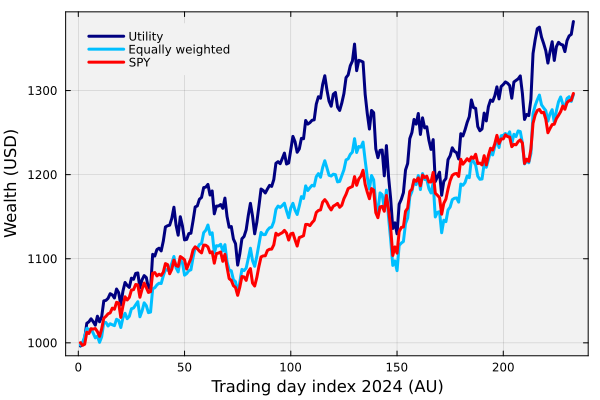

In [39]:
let
    q = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
    plot(q, wealth_utility_max[:,end], lw=3, label="Utility", c=:navy)
    plot!(wealth_equally_weighted[:,end], lw=3, label="Equally weighted", c=:deepskyblue1);
    plot!(wealth_SPY, lw=3, label="SPY", c=:red);
    xlabel!("Trading day index 2024 (AU)", fontsize=18);
    ylabel!("Wealth (USD)", fontsize=18);
end

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.